##Machine Translation

### Dataset Definition

The dataset is obtained from kaggle, and we will be using this dataset for Language Translation task (English to French). There are 2 columns, one column contains english words/sentences and the other column contains its corresponding french translation.

###1. Import Libraries and download resources

In [1]:
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.cli import download
import nltk
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Flatten, Input, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
download("en_core_web_sm")
nltk.download("punkt_tab")
nltk.download("stopwords")

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Define NLTK stopwords
nltk_stopwords = set(stopwords.words("english"))

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


###2. Load and explore the dataset

In [3]:
df = pd.read_csv('eng_-french.csv')

# Display a sample of the dataset
print("Dataset Overview:")
print(df.head())

Dataset Overview:
  English words/sentences French words/sentences
0                     Hi.                 Salut!
1                    Run!                Cours !
2                    Run!               Courez !
3                    Who?                  Qui ?
4                    Wow!             Ça alors !


In [4]:
df = df.sample(n=10000, random_state=42).reset_index(drop=True)
df.columns = ["English", "French"]

print("\nSample Data:")
print(df.head())


Sample Data:
                                        English  \
0                                  Take a seat.   
1                          I wish Tom was here.   
2                      How did the audition go?   
3  I've no friend to talk to about my problems.   
4    I really like this skirt. Can I try it on?   

                                              French  
0                                     Prends place !  
1                        J'aimerais que Tom soit là.  
2                  Comment s'est passée l'audition ?  
3  Je n'ai pas d'ami avec lequel je puisse m'entr...  
4    J'aime beaucoup cette jupe, puis-je l'essayer ?  


###3. Text Preprocessing (Data cleaning with spacy and nltk)

For data cleaning we will be using spacy and nltk library to lowercase text, remove punctuations, tokenizing and removing stop words

In [5]:
# Clean using SpaCy
def clean_text_spacy(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    doc = nlp(text)
    cleaned_text = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return cleaned_text

df["Cleaned_SpaCy"] = df["English"].apply(clean_text_spacy)

In [6]:
# Clean using NLTK
def clean_text_nltk(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    words = nltk.word_tokenize(text)
    cleaned_text = " ".join([word for word in words if word not in nltk_stopwords])
    return cleaned_text

df["Cleaned_NLTK"] = df["English"].apply(clean_text_nltk)

In [7]:
print("\nCleaned Text Examples:")
print(df[["English", "Cleaned_SpaCy", "Cleaned_NLTK"]].head())


Cleaned Text Examples:
                                        English           Cleaned_SpaCy  \
0                                  Take a seat.                    seat   
1                          I wish Tom was here.                wish tom   
2                      How did the audition go?                audition   
3  I've no friend to talk to about my problems.  ve friend talk problem   
4    I really like this skirt. Can I try it on?          like skirt try   

               Cleaned_NLTK  
0                 take seat  
1                  wish tom  
2               audition go  
3  ive friend talk problems  
4     really like skirt try  


###4. Data Visualization

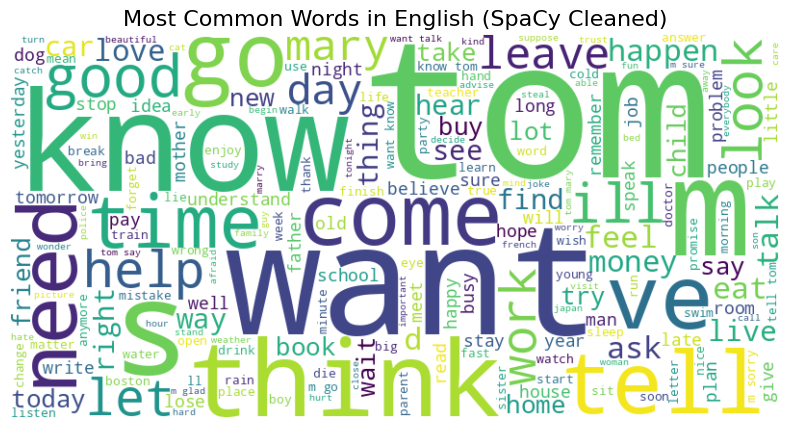

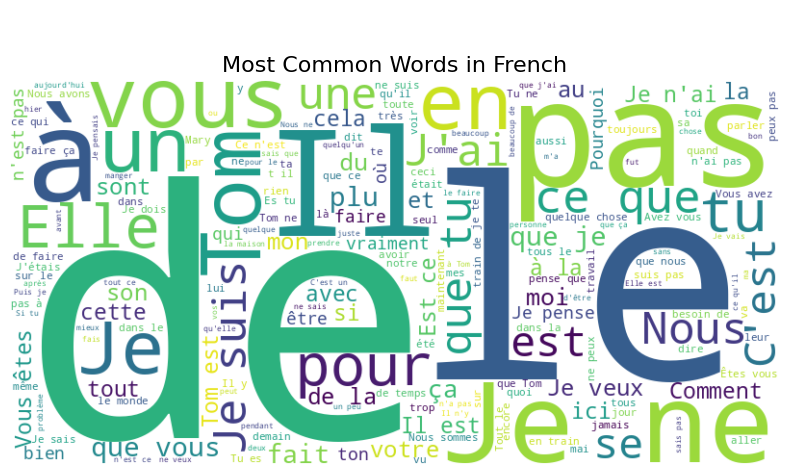

In [8]:
english_text = " ".join(df["Cleaned_SpaCy"])
french_text = " ".join(df["French"])

# Function to generate and display a word cloud
def generate_word_cloud(text, title, color="white"):
    wordcloud = WordCloud(width=800, height=400, background_color=color, colormap="viridis").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Generate word cloud for English text
generate_word_cloud(english_text, "Most Common Words in English (SpaCy Cleaned)", color="white")

# Generate word cloud for French text
generate_word_cloud(french_text, "\n\nMost Common Words in French", color="white")

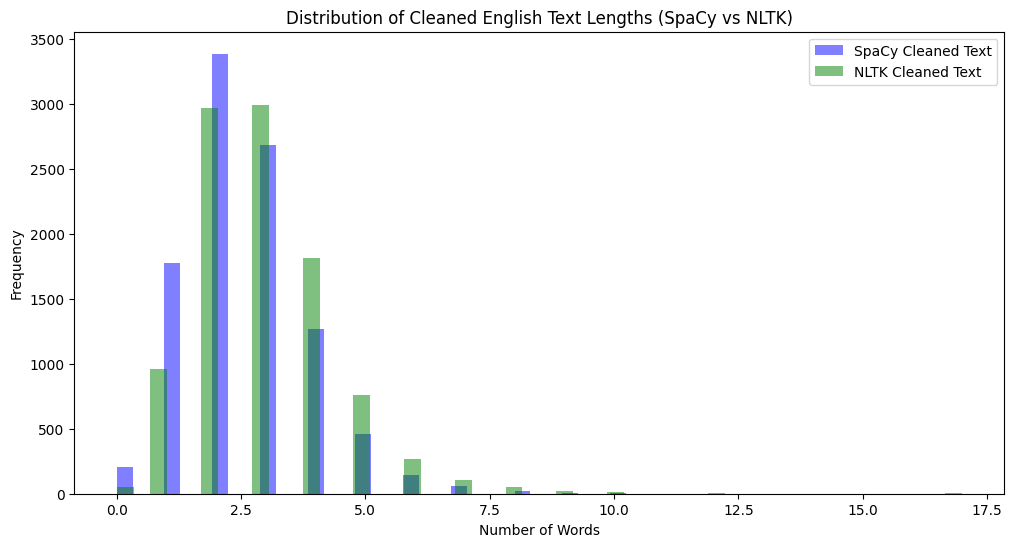

In [9]:
import matplotlib.pyplot as plt

# Calculate lengths of cleaned texts
df['SpaCy_Length'] = df['Cleaned_SpaCy'].apply(lambda x: len(x.split()))
df['NLTK_Length'] = df['Cleaned_NLTK'].apply(lambda x: len(x.split()))

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(df['SpaCy_Length'], bins=50, alpha=0.5, label='SpaCy Cleaned Text', color='blue')
plt.hist(df['NLTK_Length'], bins=50, alpha=0.5, label='NLTK Cleaned Text', color='green')
plt.title('Distribution of Cleaned English Text Lengths (SpaCy vs NLTK)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

###5. Tokenization and Padding

In [10]:
# Tokenizer for English (SpaCy-cleaned)
eng_tokenizer_spacy = Tokenizer()
eng_tokenizer_spacy.fit_on_texts(df["Cleaned_SpaCy"])
eng_sequences_spacy = eng_tokenizer_spacy.texts_to_sequences(df["Cleaned_SpaCy"])
eng_padded_spacy = pad_sequences(eng_sequences_spacy, padding="post")

# Tokenizer for English (NLTK-cleaned)
eng_tokenizer_nltk = Tokenizer()
eng_tokenizer_nltk.fit_on_texts(df["Cleaned_NLTK"])
eng_sequences_nltk = eng_tokenizer_nltk.texts_to_sequences(df["Cleaned_NLTK"])
eng_padded_nltk = pad_sequences(eng_sequences_nltk, padding="post")

In [11]:
# Tokenizer for French
fra_tokenizer = Tokenizer()
fra_tokenizer.fit_on_texts(df["French"])
fra_sequences = fra_tokenizer.texts_to_sequences(df["French"])
fra_padded = pad_sequences(fra_sequences, padding="post")

In [12]:
# Vocabulary sizes and sequence lengths
eng_vocab_size_spacy = len(eng_tokenizer_spacy.word_index) + 1
eng_vocab_size_nltk = len(eng_tokenizer_nltk.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1

max_eng_len_spacy = eng_padded_spacy.shape[1]
max_eng_len_nltk = eng_padded_nltk.shape[1]
max_fra_len = fra_padded.shape[1]

In [13]:
# Prepare decoder output data
decoder_input_data = fra_padded[:, :-1]
decoder_output_data = fra_padded[:, 1:]

# Flatten target data for FFNN training
decoder_output_data_ffnn = decoder_output_data.flatten()

decoder_output_data = np.expand_dims(decoder_output_data, -1)

###6. Define the models (FFNN, LSTM, Bi-directional LSTM)

In [14]:
def ffnn_model(vocab_size, input_length):
    model = Sequential([
        Embedding(vocab_size, 256, input_length=input_length),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(fra_vocab_size, activation='softmax')
    ])
    return model

In [15]:
def lstm_model(vocab_size, input_length):
    encoder_inputs = Input(shape=(input_length,))
    encoder_embedding = Embedding(vocab_size, 256)(encoder_inputs)
    encoder_lstm, state_h, state_c = LSTM(512, return_state=True)(encoder_embedding)

    decoder_inputs = Input(shape=(max_fra_len - 1,))
    decoder_embedding = Embedding(fra_vocab_size, 256)(decoder_inputs)
    decoder_lstm = LSTM(512, return_sequences=True)(decoder_embedding, initial_state=[state_h, state_c])
    decoder_dense = Dense(fra_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_lstm)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

In [16]:
def bi_lstm_model(vocab_size, input_length):
    # Encoder
    encoder_inputs = Input(shape=(input_length,))
    encoder_embedding = Embedding(vocab_size, 256)(encoder_inputs)
    encoder_bilstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(
        LSTM(512, return_state=True)
    )(encoder_embedding)
    state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
    state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

    # Decoder
    decoder_inputs = Input(shape=(max_fra_len - 1,))
    decoder_embedding = Embedding(fra_vocab_size, 256)(decoder_inputs)
    decoder_lstm = LSTM(1024, return_sequences=True)(
        decoder_embedding,
        initial_state=[state_h, state_c]
    )

    # Dense output layer
    decoder_dense = Dense(fra_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_lstm)

    # Define and compile the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    return model

###6. Model Training with 3 optimizers (adam, sgd, adagrad)

In [17]:
# Define optimizers
optimizers = ['adam', 'sgd', 'adagrad']

# Function to train models with different optimizers
def train_model(model_fn, vocab_size, input_length, x_train, y_train):
    history_results = {}
    for optimizer in optimizers:
        print(f"Training with optimizer: {optimizer}")
        model = model_fn(vocab_size, input_length)
        model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(
            x_train,
            y_train,
            batch_size=64,
            epochs=5,
            validation_split=0.2,
            verbose=1
        )
        history_results[optimizer] = history.history
    return history_results

In [18]:
# Train FFNN with SpaCy-cleaned data
print("\nTraining FFNN with SpaCy-cleaned data...")
ffnn_results_spacy = train_model(ffnn_model,
                                eng_vocab_size_spacy,
                                max_eng_len_spacy,
                                eng_padded_spacy,
                                decoder_output_data_ffnn)

# Train FFNN with NLTK-cleaned data
print("\nTraining FFNN with NLTK-cleaned data...")
ffnn_results_nltk = train_model(ffnn_model,
                                eng_vocab_size_nltk,
                                max_eng_len_nltk,
                                eng_padded_nltk,
                                decoder_output_data_ffnn)


Training FFNN with SpaCy-cleaned data...
Training with optimizer: adam


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8172 - loss: 2.9828 - val_accuracy: 0.8510 - val_loss: 1.5316
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8547 - loss: 1.2801 - val_accuracy: 0.8510 - val_loss: 1.6331
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8552 - loss: 1.1825 - val_accuracy: 0.8510 - val_loss: 1.7056
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8574 - loss: 1.1075 - val_accuracy: 0.8510 - val_loss: 1.8756
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8576 - loss: 1.0558 - val_accuracy: 0.8510 - val_loss: 1.9283
Training with optimizer: sgd
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7603 - loss: 7.9860 - val_accuracy: 0.8510 - val_loss: 1.7739
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8625 - loss: 1.6490 - val_accuracy: 0.8510 - val_loss: 1.7550
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8593 - loss: 1.

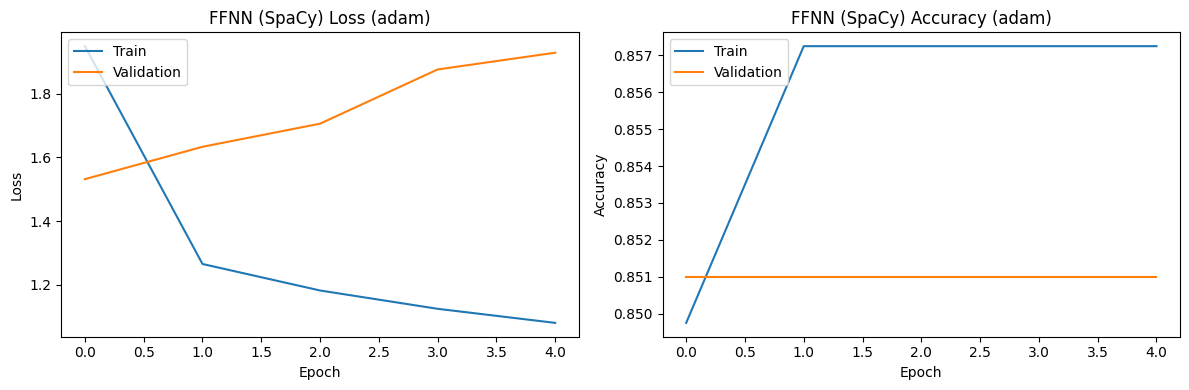

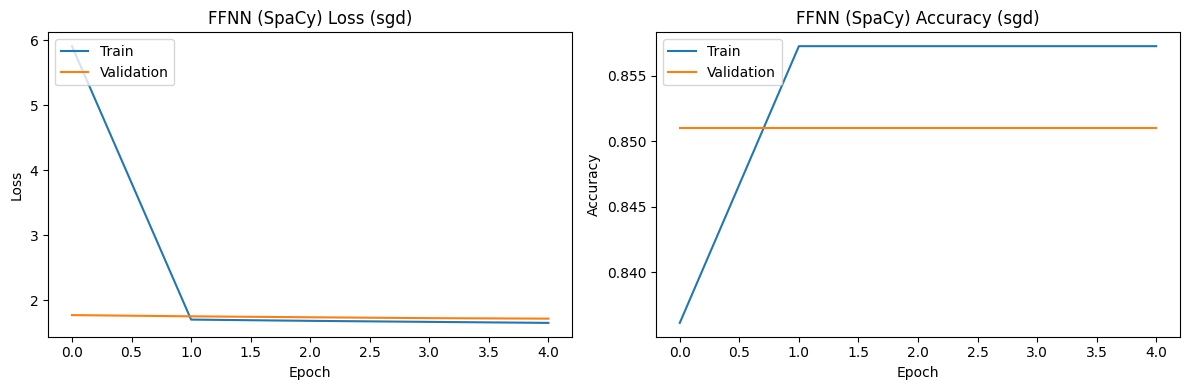

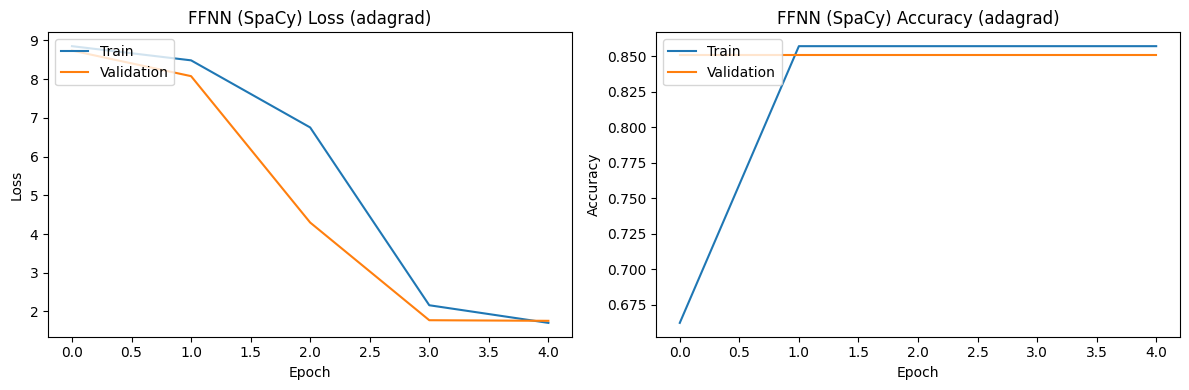

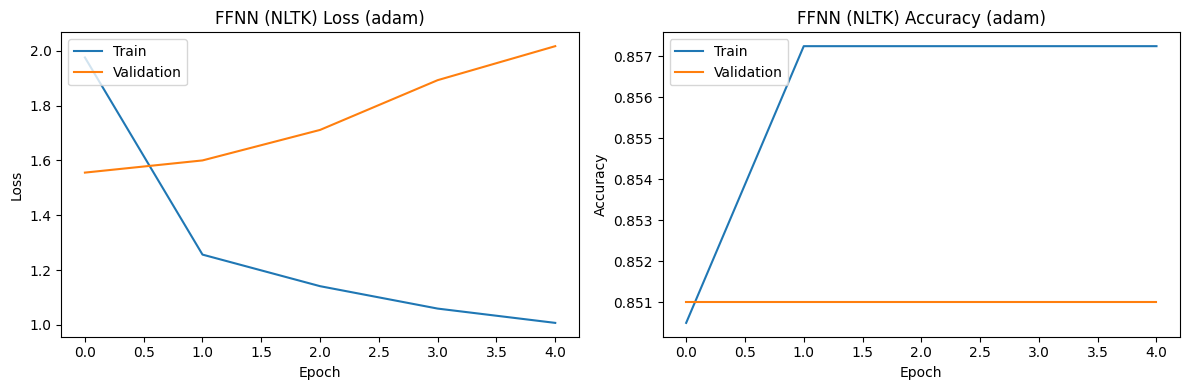

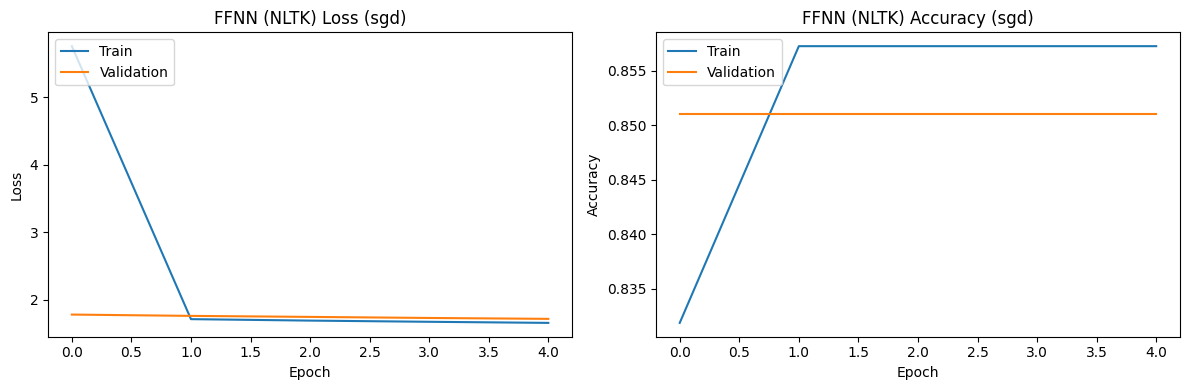

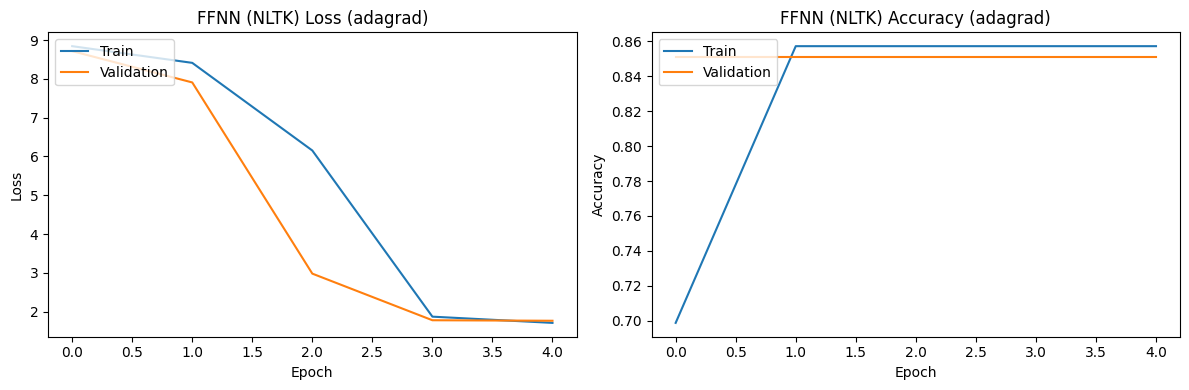

In [27]:
def plot_history(history_results, model_name):
    for optimizer, history in history_results.items():
        plt.figure(figsize=(12, 4))

        # Plot training & validation loss values
        plt.subplot(1, 2, 1)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title(f'{model_name} Loss ({optimizer})')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 2)
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title(f'{model_name} Accuracy ({optimizer})')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')


        plt.tight_layout()
        plt.show()

plot_history(ffnn_results_spacy, 'FFNN (SpaCy)')
plot_history(ffnn_results_nltk, 'FFNN (NLTK)')

In [19]:
# Train LSTM with SpaCy-cleaned data
print("\nTraining LSTM with SpaCy-cleaned data...")
lstm_results_spacy = train_model(lstm_model,
                                eng_vocab_size_spacy,
                                max_eng_len_spacy,
                                [eng_padded_spacy, decoder_input_data],
                                decoder_output_data)

# Train LSTM with NLTK-cleaned data
print("\nTraining LSTM with NLTK-cleaned data...")
lstm_results_nltk = train_model(lstm_model,
                               eng_vocab_size_nltk,
                               max_eng_len_nltk,
                               [eng_padded_nltk, decoder_input_data],
                               decoder_output_data)


Training LSTM with SpaCy-cleaned data...
Training with optimizer: adam
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.8188 - loss: 2.3860 - val_accuracy: 0.8570 - val_loss: 1.0491
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.8580 - loss: 1.0124 - val_accuracy: 0.8584 - val_loss: 1.0143
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.8588 - loss: 0.9693 - val_accuracy: 0.8612 - val_loss: 0.9852
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.8617 - loss: 0.9181 - val_accuracy: 0.8634 - val_loss: 0.9595
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8651 - loss: 0.8763 - val_accuracy: 0.8657 - val_loss: 0.9403
Training with optimizer: sgd
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.7910 - loss: 8.5890 - val_accuracy: 0.8543 - val_loss: 2.6645
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.8538 - loss: 1.7860 - val_accuracy: 0.8543 - val_loss: 1.44

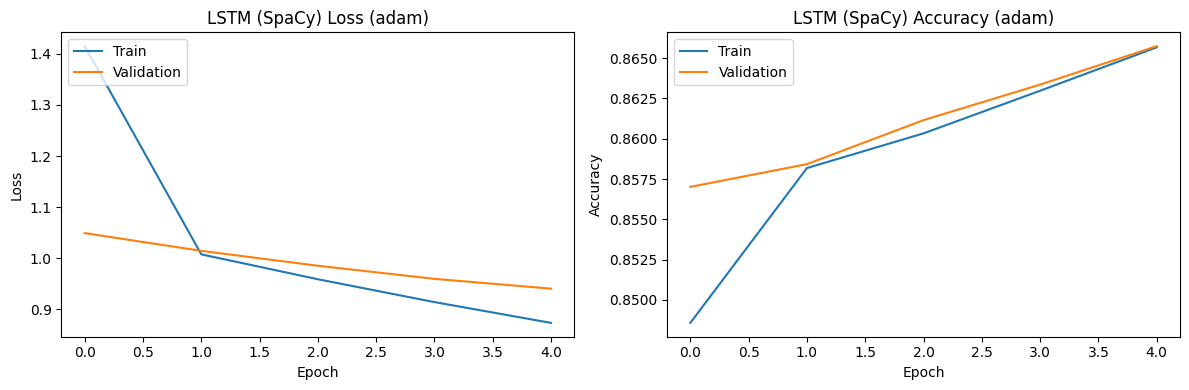

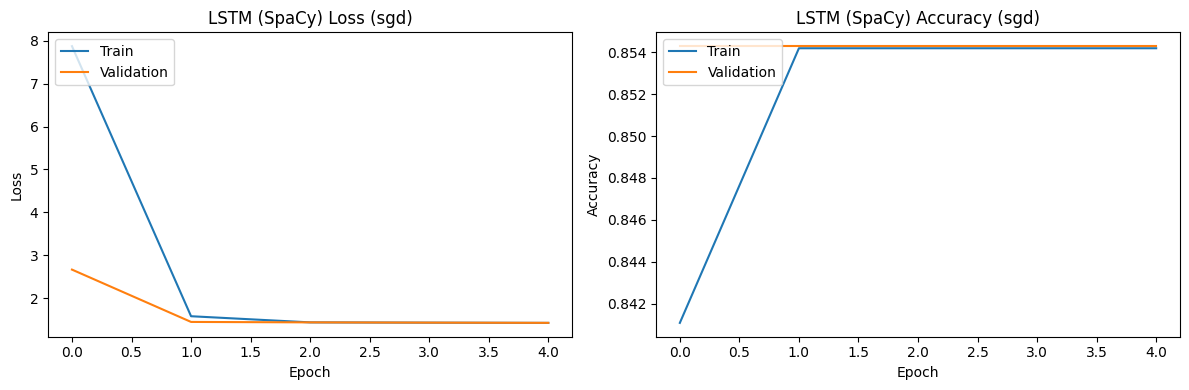

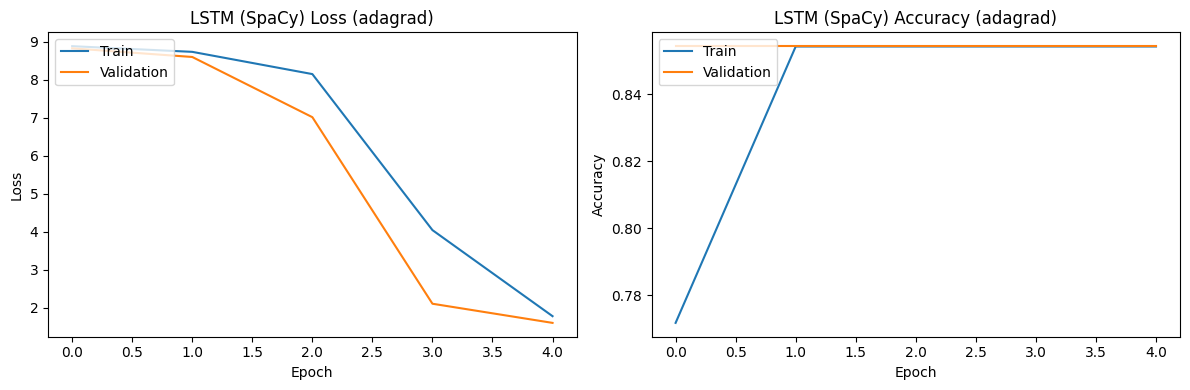

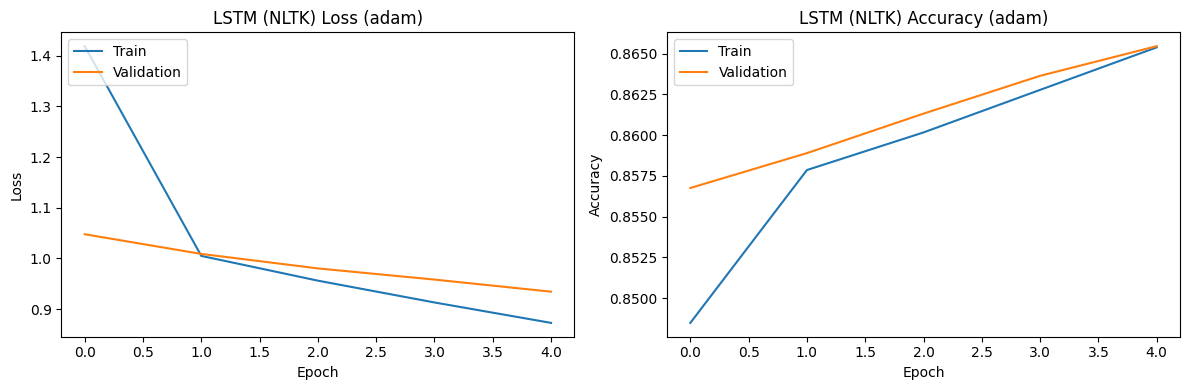

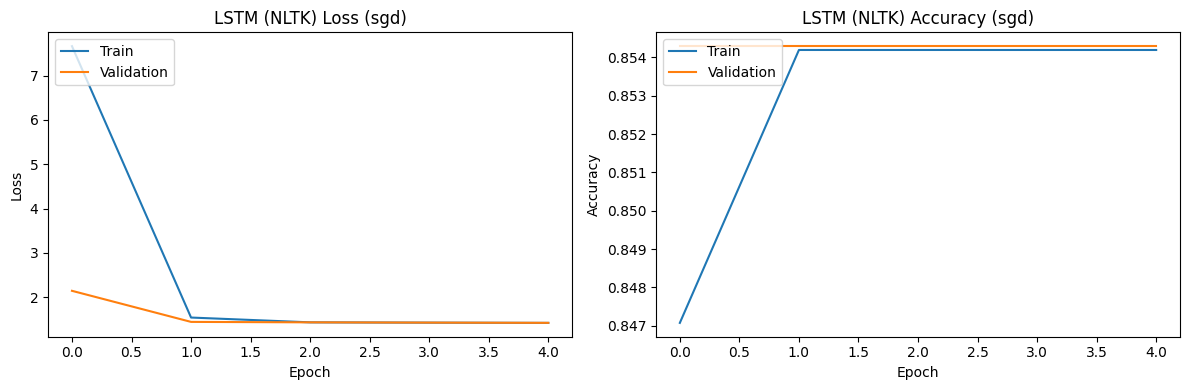

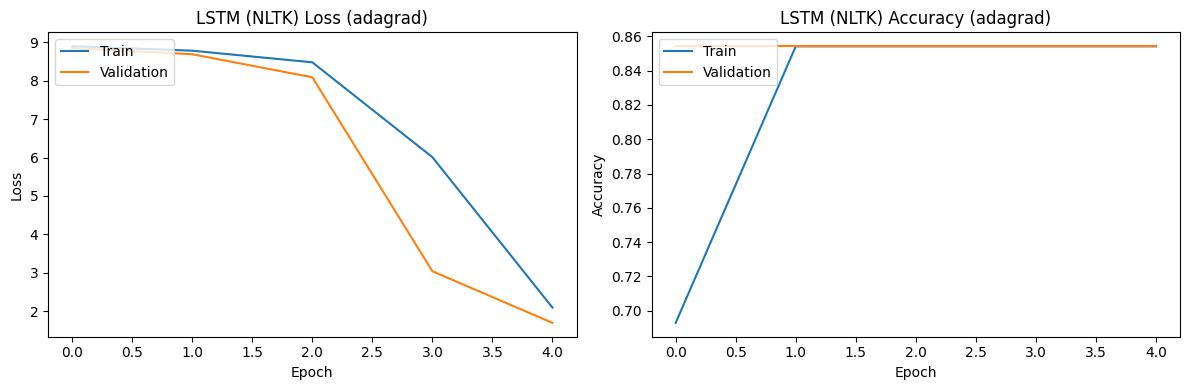

In [29]:
plot_history(lstm_results_spacy, 'LSTM (SpaCy)')
plot_history(lstm_results_nltk, 'LSTM (NLTK)')

In [20]:
# Train Bidirectional LSTM with SpaCy-cleaned data
print("\nTraining Bidirectional LSTM with SpaCy-cleaned data...")
bilstm_results_spacy = train_model(bi_lstm_model,
                                   eng_vocab_size_spacy,
                                   max_eng_len_spacy,
                                   [eng_padded_spacy, decoder_input_data],
                                   decoder_output_data)

# Train Bidirectional LSTM with NLTK-cleaned data
print("\nTraining Bidirectional LSTM with NLTK-cleaned data...")
bilstm_results_nltk = train_model(bi_lstm_model,
                                  eng_vocab_size_nltk,
                                  max_eng_len_nltk,
                                  [eng_padded_nltk, decoder_input_data],
                                  decoder_output_data)


Training Bidirectional LSTM with SpaCy-cleaned data...
Training with optimizer: adam
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.8197 - loss: 2.0240 - val_accuracy: 0.8581 - val_loss: 1.0297
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.8580 - loss: 0.9865 - val_accuracy: 0.8622 - val_loss: 0.9785
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.8636 - loss: 0.9035 - val_accuracy: 0.8660 - val_loss: 0.9436
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - accuracy: 0.8686 - loss: 0.8320 - val_accuracy: 0.8688 - val_loss: 0.9172
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.8708 - loss: 0.7825 - val_accuracy: 0.8707 - val_loss: 0.8957
Training with optimizer: sgd
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.7993 - loss: 8.4006 - val_accuracy: 0.8543 - val_loss: 1.7052
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.8556 - loss: 1.5516 - val_accuracy: 0

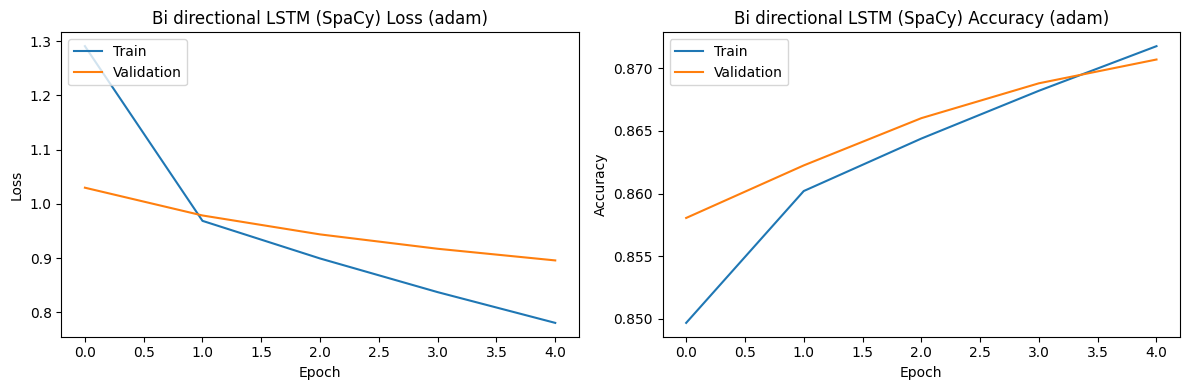

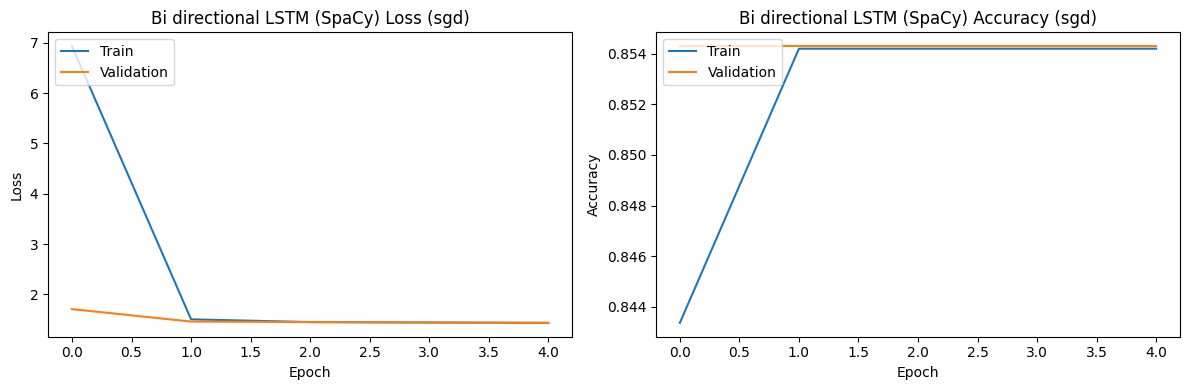

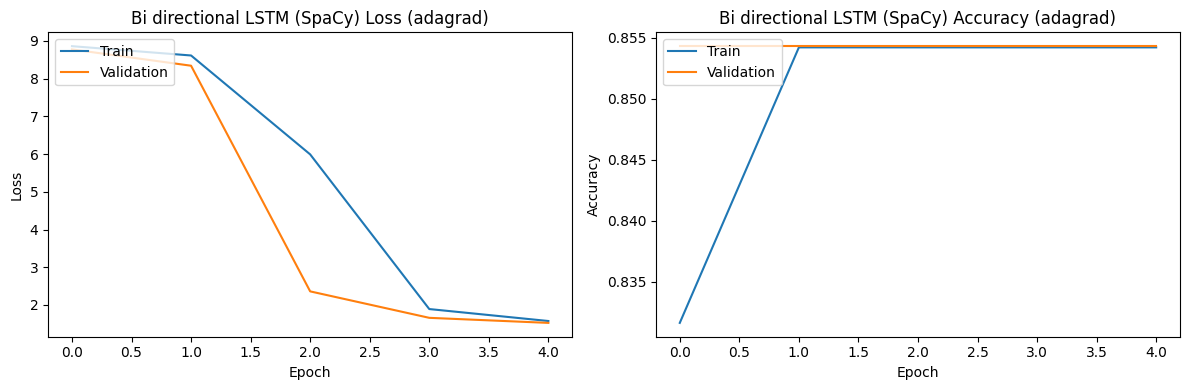

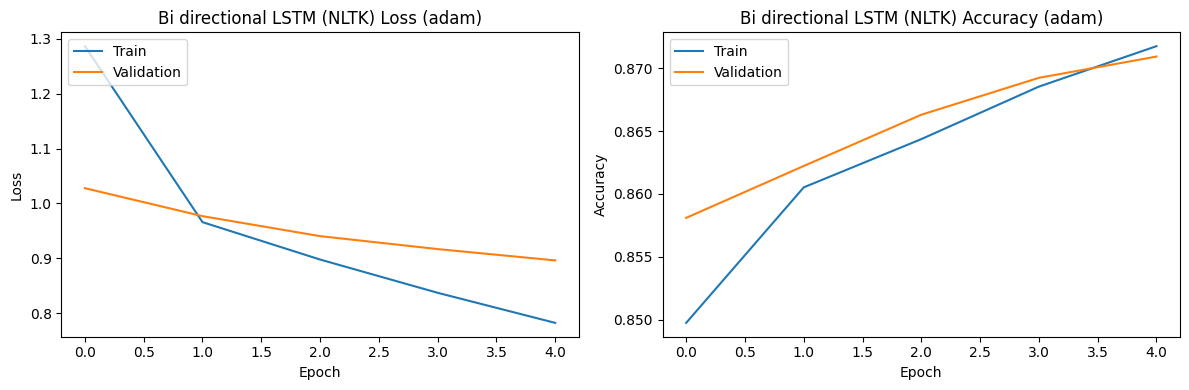

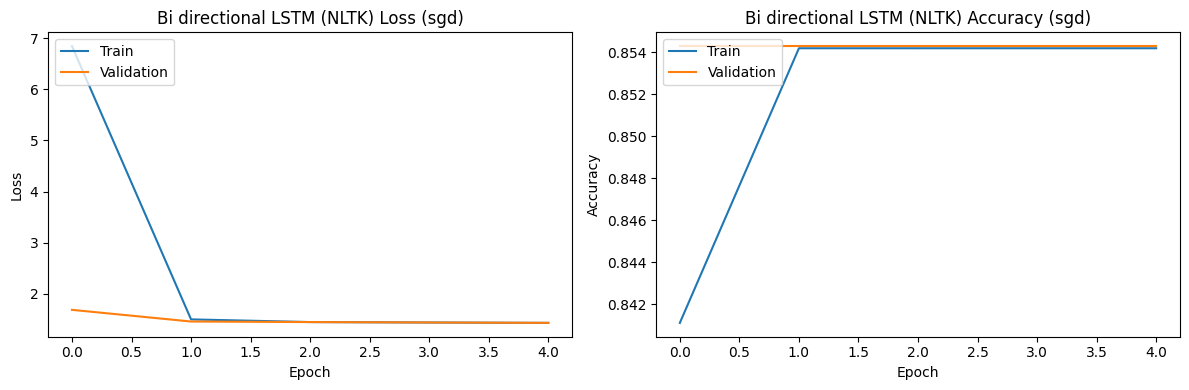

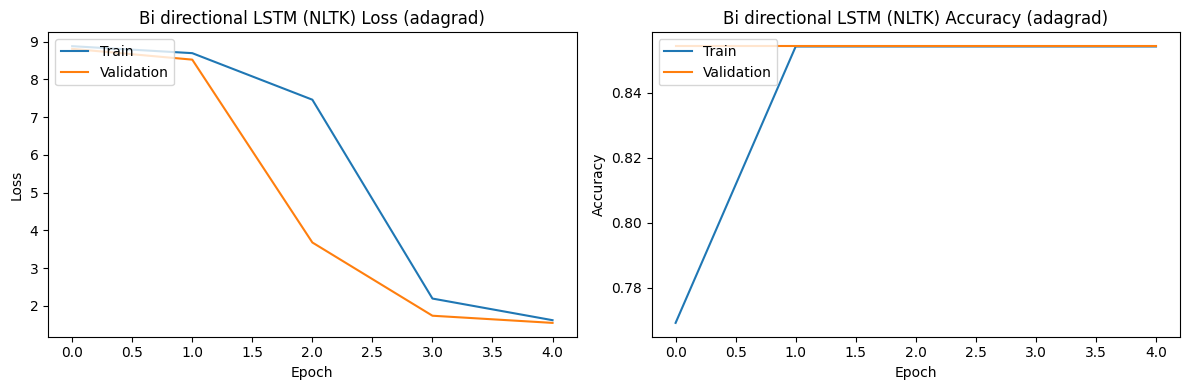

In [30]:
plot_history(bilstm_results_spacy, 'Bi directional LSTM (SpaCy)')
plot_history(bilstm_results_nltk, 'Bi directional LSTM (NLTK)')

###7. Compare the results

In [21]:
def results_table(history_results, model_name, data_source):
    results = []
    for optimizer, history in history_results.items():
        results.append({
            'Model': model_name,
            'Data Cleaning': data_source,
            'Optimizer': optimizer,
            'Training Accuracy': history['accuracy'][-1],
            'Validation Accuracy': history['val_accuracy'][-1],
            'Training Loss': history['loss'][-1],
            'Validation Loss': history['val_loss'][-1]
        })
    return results


all_results = []

all_results.extend(results_table(ffnn_results_spacy, 'FFNN', 'SpaCy'))
all_results.extend(results_table(ffnn_results_nltk, 'FFNN', 'NLTK'))
all_results.extend(results_table(lstm_results_spacy, 'LSTM', 'SpaCy'))
all_results.extend(results_table(lstm_results_nltk, 'LSTM', 'NLTK'))
all_results.extend(results_table(bilstm_results_spacy, 'Bi-LSTM', 'SpaCy'))
all_results.extend(results_table(bilstm_results_nltk, 'Bi-LSTM', 'NLTK'))


results_df = pd.DataFrame(all_results)
results_df


,Model,Data Cleaning,Optimizer,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,FFNN,SpaCy,adam,0.857250,0.851000,1.080739,1.928263
1,FFNN,SpaCy,sgd,0.857250,0.851000,1.654093,1.719285
2,FFNN,SpaCy,adagrad,0.857250,0.851000,1.705682,1.759151
3,FFNN,NLTK,adam,0.857250,0.851000,1.007272,2.016360
4,FFNN,NLTK,sgd,0.857250,0.851000,1.655930,1.715681
5,FFNN,NLTK,adagrad,0.857250,0.851000,1.710048,1.764983
6,LSTM,SpaCy,adam,0.865670,0.865744,0.873315,0.940339
7,LSTM,SpaCy,sgd,0.854195,0.854295,1.422261,1.423080
8,LSTM,SpaCy,adagrad,0.854196,0.854295,1.779932,1.603246
9,LSTM,NLTK,adam,0.865388,0.865462,0.872954,0.934514


Based on the training results, we can see Bi-directional LSTM with Spacy data cleaning and adam optimizer has the best performance among all the models having

- Training Accuracy: 0.872

- Validation Accuracy: 0.871

- Training Loss: 0.78

- Validation Loss: 0.89

This combination outperforms all others in terms of both accuracy and loss, making it the best model for this task.

###Observations on Models:

In several cases (e.g., SGD and Adagrad for FFNN, LSTM, Bi-LSTM), training accuracy and validation accuracy are identical across epochs. This could be because model may have memorized simple patterns in the training data that are also present in the validation set, leading to identical accuracies.
The other reason could be because optimizers like SGD and Adagrad converge slowly or get stuck in local minima, which could reflect similarly on validation accuracy.

###References

1. https://www.tensorflow.org/guide/keras/working_with_rnns

2. https://spacy.io/usage/spacy-101

3. https://realpython.com/nltk-nlp-python/

4. https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench?resource=download